In [39]:
import matplotlib.pyplot as plt
from math import exp, sin, pi, cos
from numpy import linspace

In [40]:
def tk(k, tau):
    return k * tau

def xi(L, i, h):
    return L + i * h

In [41]:
def Phi_L(t, a, b, c):
    return exp((c - a) * t) * (cos(b * t) + sin(b * t))

def Phi_R(t, a, b, c):
    return -exp((c - a) * t) * (cos(b * t) + sin(b * t))

def Psi(x):
    return sin(x)

In [42]:
def analytic(t, x, a, b, c):
    return exp((c - a) * t) * sin(x + b * t)

In [43]:
def explicit(n, L, R, K, T, a, b, c, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    assert sigma * a <= 0.5
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(1, K + 1):
        for i in range(1, n):
            u[k][i] = (
                (a * sigma + b * h * sigma / 2) * u[k - 1][i + 1] +
                (1 - 2 * a * sigma + c * tau) * u[k - 1][i] +
                (a * sigma - b * h * sigma / 2) * u[k - 1][i - 1]
            )
        if approx == 1:
            u[k][0] = (Phi_L(tk(k, tau), a, b, c) * h - u[k][1]) / (h - 1)
            u[k][-1] = (Phi_R(tk(k, tau), a, b, c) * h + u[k][-2]) / (h + 1)
        
        elif approx == 2:
            u[k][0] = (Phi_L(tk(k, tau), a, b, c) * 2 * h + u[k][2] - 4 * u[k][1]) / (2 * h - 3)
            u[k][-1] = (Phi_R(tk(k, tau), a, b, c) * 2 * h + 4 * u[k][-2] - u[k][-3]) / (2 * h + 3)
        
        elif approx == 3:
            u[k][0] = (
                (
                    u[k][1] - h * Phi_L(tk(k, tau), a, b, c) +
                    (h**2 / (2 * a * tau)) * u[k - 1][0] + 
                    (b * h**2 / (2 * a)) * Phi_L(tk(k, tau), a, b, c)
                ) / (
                    1 - h + (h**2 / (2 * a * tau)) + 
                    (b * h**2 / (2 * a)) - (c * h**2 / (2 * a))
                )
            )
            u[k][-1] = (
                (
                    u[k][-2] + h * Phi_R(tk(k, tau), a, b, c) +
                    (h**2 / (2 * a * tau)) * u[k - 1][-1] +
                    (b * h**2 / (2 * a)) * Phi_R(tk(k, tau), a, b, c)
                ) / (
                    1 + h + (h**2 / (2 * a * tau)) + 
                    (b * h**2 / (2 * a)) - (c * h**2 / (2 * a))
                )
            )
            
    return u

In [44]:
def TMA(a, b, c, d):
    n = len(d)
    P = [0 for _ in range(n)]
    Q = [0 for _ in range(n)]
    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]
    for i in range(1, n - 1):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[-1] = 0
    Q[-1] = (d[n - 1] - a[n - 1] * Q[n - 2]) / (b[n - 1] + a[n - 1] * P[n - 2])
    x = [0 for _ in range(n)]
    x[-1] = Q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [45]:
def implicit(n, L, R, K, T, a, b, c, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    _a = [0.0 for _ in range(n + 1)]
    _b = [0.0 for _ in range(n + 1)]
    _c = [0.0 for _ in range(n + 1)]
    _d = [0.0 for _ in range(n + 1)]
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(K):
        for i in range(1, n):
            _a[i] = a * sigma - b * (sigma * h / 2)
            _b[i] = -2 * a * sigma + c * tau - 1
            _c[i] = a * sigma + b * (sigma * h / 2)
            _d[i] = -u[k][i]
        if approx == 1:
            _a[0] = 0
            _b[0] = -1 + h
            _c[0] = 1
            _d[0] = Phi_L(tk(k + 1, tau), a, b, c) * h
            _a[-1] = -1
            _b[-1] = 1 + h
            _c[-1] = 0
            _d[-1] = Phi_R(tk(k + 1, tau), a, b, c) * h
        elif approx == 2:
            _a[0] = 0
            _b[0] = -3 + 2 * h + ((a * sigma - b * sigma * h / 2) / (a * sigma + b * sigma * h / 2))
            _c[0] = 4 + (c * tau - 2 * a * sigma - 1) / (a * sigma + b * sigma * h / 2)
            _d[0] = (
                Phi_L(tk(k + 1, tau), a, b, c) * 2 * h - u[k][1] / (a * sigma + b * sigma * h / 2)
            )
            _a[-1] = -4 - (c * tau - 2 * a * sigma - 1) / (a * sigma - b * sigma * h / 2)
            _b[-1] = 3 + 2 * h - ((a * sigma + b * sigma * h / 2) / (a * sigma - b * sigma * h / 2))
            _c[-1] = 0
            _d[-1] = (
                Phi_R(tk(k + 1, tau), a, b, c) * 2 * h + u[k][-2] / (a * sigma - b * sigma * h / 2)
            )
        elif approx == 3:

            _a[0] = 0
            _b[0] = -3 + 2*h + _a[1]/_c[1]
            _c[0] = 4 + _b[1]/_c[1]
            _d[0] = 2*h * Phi_L(tk(k+1,tau), a,b,c) - u[k][1]/_c[1]

            _a[-1] = -4 - _b[-2]/_a[-2]
            _b[-1] = 3 + 2*h - _c[-2]/_a[-2]
            _c[-1] = 0
            _d[-1] = 2*h * Phi_R(tk(k+1,tau), a,b,c) + u[k][-2]/_a[-2]

        solve = TMA(_a, _b, _c, _d)
        for i in range(n + 1):
            u[k + 1][i] = solve[i]
    return u

In [46]:
def crank_nicolson(n, L, R, K, T, a, b, c, theta=0.5, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    _a = [0.0 for _ in range(n + 1)]
    _b = [0.0 for _ in range(n + 1)]
    _c = [0.0 for _ in range(n + 1)]
    _d = [0.0 for _ in range(n + 1)]
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(K):
        for i in range(1, n):
            _a[i] = -(a*theta/h**2 - b*theta/(2*h))
            _b[i] = 1/tau + 2*a*theta/h**2 - c*theta
            _c[i] = -(a*theta/h**2 + b*theta/(2*h))
            _d[i] = (
                (1/tau)*u[k][i] + (1-theta)*(a*(u[k][i+1]-2*u[k][i]+u[k][i-1])/(h**2)+
                                             b*(u[k][i+1]-u[k][i-1])/(2*h)+c*u[k][i])
            )
        if approx == 1:
            _a[0] = 0
            _b[0] = -1 + h
            _c[0] = 1
            _d[0] = Phi_L(tk(k + 1, tau), a, b, c) * h
            _a[-1] = -1
            _b[-1] = 1 + h
            _c[-1] = 0
            _d[-1] = Phi_R(tk(k + 1, tau), a, b, c) * h
        elif approx == 2:
            _a[0] = 0
            _b[0] = -3 + 2 * h + ((a * sigma - b * sigma * h / 2) / (a * sigma + b * sigma * h / 2))
            _c[0] = 4 + (c * tau - 2 * a * sigma - 1) / (a * sigma + b * sigma * h / 2)
            _d[0] = (
                Phi_L(tk(k + 1, tau), a, b, c) * 2 * h - u[k][1] / (a * sigma + b * sigma * h / 2)
            )
            _a[-1] = -4 - (c * tau - 2 * a * sigma - 1) / (a * sigma - b * sigma * h / 2)
            _b[-1] = 3 + 2 * h - ((a * sigma + b * sigma * h / 2) / (a * sigma - b * sigma * h / 2))
            _c[-1] = 0
            _d[-1] = (
                Phi_R(tk(k + 1, tau), a, b, c) * 2 * h + u[k][-2] / (a * sigma - b * sigma * h / 2)
            )
        elif approx == 3:

            _a[0] = 0
            _b[0] = -3 + 2*h + (sigma - (b*tau) / (2*h)) / (sigma + (b*tau) / (2*h))
            _c[0] = 4 + (-1 - 2*sigma + c*tau) / (sigma + (b*tau) / (2*h))
            _d[0] = 2*h * Phi_L(tk(k+1,tau), a,b,c) - u[k][1] / (sigma + (b*tau) / (2*h))

            _a[-1] = -4 - (-1 - 2*sigma + c*tau) / (sigma - (b*tau) / (2*h))
            _b[-1] = 3 + 2*h - (sigma + (b*tau) / (2*h)) / (sigma - (b*tau) / (2*h))
            _c[-1] = 0
            _d[-1] = 2*h * Phi_R(tk(k+1,tau), a,b,c) + u[k][-2] / (sigma - (b*tau) / (2*h))


        solve = TMA(_a, _b, _c, _d)
        for i in range(n + 1):
            u[k + 1][i] = solve[i]
    return u

In [47]:
L = 0
R = pi

T = 10
n = 100
K = 50000

a = 1
b = 10
c = -10

u_explicit_1 = explicit(n, L, R, K, T, a, b, c, approx=1)
u_explicit_2 = explicit(n, L, R, K, T, a, b, c, approx=2)
u_explicit_3 = explicit(n, L, R, K, T, a, b, c, approx=3)
u_implicit_1 = implicit(n, L, R, K, T, a, b, c, approx=1)
u_implicit_2 = implicit(n, L, R, K, T, a, b, c, approx=2)
u_implicit_3 = implicit(n, L, R, K, T, a, b, c, approx=3)
u_crank_nicolson_1 = crank_nicolson(n, L, R, K, T, a, b, c, approx=1)
u_crank_nicolson_2 = crank_nicolson(n, L, R, K, T, a, b, c, approx=2)
u_crank_nicolson_3 = crank_nicolson(n, L, R, K, T, a, b, c, approx=3)

In [48]:
tau = T / K
h = (R - L) / n

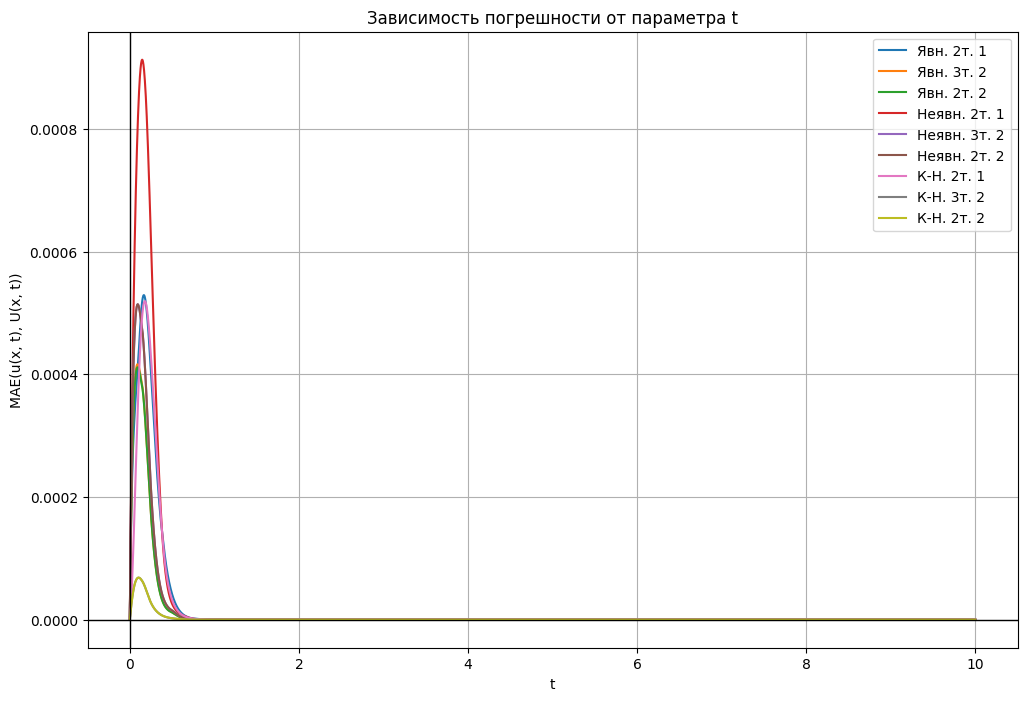

In [49]:
time = linspace(0, T, K + 1)
mae_u_explicit_1 = [0 for _ in range(K + 1)]
mae_u_explicit_2 = [0 for _ in range(K + 1)]
mae_u_explicit_3 = [0 for _ in range(K + 1)]
mae_u_implicit_1 = [0 for _ in range(K + 1)]
mae_u_implicit_2 = [0 for _ in range(K + 1)]
mae_u_implicit_3 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_1 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_2 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_3 = [0 for _ in range(K + 1)]
for k in range(K + 1):
    for i in range(n + 1):
        mae_u_explicit_1[k] += abs(u_explicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_explicit_2[k] += abs(u_explicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_explicit_3[k] += abs(u_explicit_3[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_implicit_1[k] += abs(u_implicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_implicit_2[k] += abs(u_implicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_implicit_3[k] += abs(u_implicit_3[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_crank_nicolson_1[k] += abs(u_crank_nicolson_1[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_crank_nicolson_2[k] += abs(u_crank_nicolson_2[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
        mae_u_crank_nicolson_3[k] += abs(u_crank_nicolson_3[k][i] - analytic(tk(k, tau), xi(L, i, h), a, b, c))
    mae_u_explicit_1[k] /= n
    mae_u_explicit_2[k] /= n
    mae_u_explicit_3[k] /= n
    mae_u_implicit_1[k] /= n
    mae_u_implicit_2[k] /= n
    mae_u_implicit_3[k] /= n
    mae_u_crank_nicolson_1[k] /= n
    mae_u_crank_nicolson_2[k] /= n
    mae_u_crank_nicolson_3[k] /= n
plt.figure(figsize=(12, 8))
plt.plot(time, mae_u_explicit_1, label="Явн. 2т. 1")
plt.plot(time, mae_u_explicit_2, label="Явн. 3т. 2")
plt.plot(time, mae_u_explicit_3, label="Явн. 2т. 2")
plt.plot(time, mae_u_implicit_1, label="Неявн. 2т. 1")
plt.plot(time, mae_u_implicit_2, label="Неявн. 3т. 2")
plt.plot(time, mae_u_implicit_3, label="Неявн. 2т. 2")
plt.plot(time, mae_u_crank_nicolson_1, label="К-Н. 2т. 1")
plt.plot(time, mae_u_crank_nicolson_2, label="К-Н. 3т. 2")
plt.plot(time, mae_u_crank_nicolson_3, label="К-Н. 2т. 2")
plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

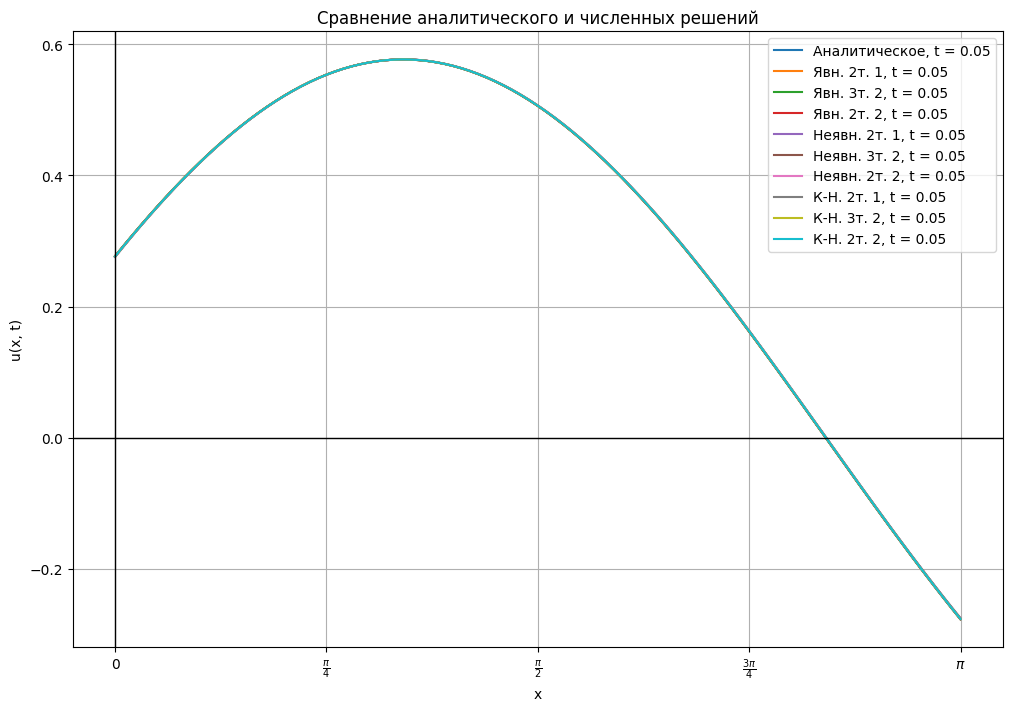

In [ ]:
time_index = 250
x = linspace(L, R, n + 1)
plt.figure(figsize=(12, 8))
current_time = tk(time_index, tau)
u_analyti_cvalues = [analytic(current_time, xi(L, i, h), a, b, c) for i in range(n + 1)]
u_explicit_1_values = [u_explicit_1[time_index][i] for i in range(n + 1)]
u_explicit_2_values = [u_explicit_2[time_index][i] for i in range(n + 1)]
u_explicit_3_values = [u_explicit_3[time_index][i] for i in range(n + 1)]
u_implicit_1_values = [u_implicit_1[time_index][i] for i in range(n + 1)]
u_implicit_2_values = [u_implicit_2[time_index][i] for i in range(n + 1)]
u_implicit_3_values = [u_implicit_3[time_index][i] for i in range(n + 1)]
u_crank_nicolson_1_values = [u_crank_nicolson_1[time_index][i] for i in range(n + 1)]
u_crank_nicolson_2_values = [u_crank_nicolson_2[time_index][i] for i in range(n + 1)]
u_crank_nicolson_3_values = [u_crank_nicolson_3[time_index][i] for i in range(n + 1)]
plt.plot(x, u_analyti_cvalues, label=f'Аналитическое, t = {current_time}')
plt.plot(x, u_explicit_1_values, label=f'Явн. 2т. 1, t = {current_time}')
plt.plot(x, u_explicit_2_values, label=f'Явн. 3т. 2, t = {current_time}')
plt.plot(x, u_explicit_3_values, label=f'Явн. 2т. 2, t = {current_time}')
plt.plot(x, u_implicit_1_values, label=f'Неявн. 2т. 1, t = {current_time}')
plt.plot(x, u_implicit_2_values, label=f'Неявн. 3т. 2, t = {current_time}')
plt.plot(x, u_implicit_3_values, label=f'Неявн. 2т. 2, t = {current_time}')
plt.plot(x, u_crank_nicolson_1_values, label=f'К-Н. 2т. 1, t = {current_time}')
plt.plot(x, u_crank_nicolson_2_values, label=f'К-Н. 3т. 2, t = {current_time}')
plt.plot(x, u_crank_nicolson_3_values, label=f'К-Н. 2т. 2, t = {current_time}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Сравнение аналитического и численных решений')
plt.xticks(ticks=[0, pi/4, pi/2, 3*pi/4, pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()